In [2]:
%matplotlib inline

In [3]:
import pymc3 as pm

In [281]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from tqdm import tqdm_notebook as tqdm

In [11]:
data = pd.read_csv('census_data.csv')
data.head()

,Unnamed: 0,age,sector,edu,marital,race,sex,earning
0,0,39,State-gov,Bachelors,Never-married,White,Male,<=50K
1,1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,White,Male,<=50K
2,2,38,Private,HS-grad,Divorced,White,Male,<=50K
3,3,53,Private,11th,Married-civ-spouse,Black,Male,<=50K
4,4,28,Private,Bachelors,Married-civ-spouse,Black,Female,<=50K


Summarize the dataset. Let's just look at what happens in the private sector for now.

In [93]:
data = data[data.sector == 'Private']
summ_data = data.groupby(['age','sex','edu','earning'])[['marital']].count().reset_index()

In [94]:
summ_data_age = summ_data.groupby(['age','sex','earning'])[['marital']].sum().reset_index()

In [34]:
females = summ_data_age[summ_data_age.sex == "Female"]\
            .pivot(index='age', columns='earning', values='marital').fillna(0.0).reset_index()
females['n'] = females["<=50K"] + females[">50K"]

males = summ_data_age[summ_data_age.sex == "Male"]\
            .pivot(index='age', columns='earning', values='marital').fillna(0.0).reset_index()
males['n'] = males["<=50K"] + males[">50K"]

females.head()

earning,age,<=50K,>50K,n
0,17,140.0,0.0,140.0
1,18,206.0,0.0,206.0
2,19,268.0,0.0,268.0
3,20,269.0,0.0,269.0
4,21,253.0,2.0,255.0


In [45]:
#Needs to be a column vector
f_age = females.age.values[:, None]
f_over50k = females['>50K'].values
f_n = females.n.values

m_age = males.age.values[:, None]
m_over50k = males['>50K'].values
m_n = males.n.values

Setup the pymc model

In [48]:
with pm.Model() as admit_m:
    rho = pm.Exponential('ρ', 1)
    eta = pm.Exponential('η', 1)
    
    K = eta**2 * pm.gp.cov.ExpQuad(1, rho)
    
    gp1 = pm.gp.Latent(cov_func=K, )
    gp2 = pm.gp.Latent(cov_func=K)
    
    f = gp1.prior('gp_f', X=f_age)
    m = gp2.prior('gp_m', X=m_age)
    
    pi_f = pm.Deterministic('π_f', pm.invlogit(f))
    pi_m = pm.Deterministic('π_m', pm.invlogit(m))
    
    earning_f = pm.Binomial('female_over50k', p = pi_f, n=f_n.astype(int), 
                           observed=f_over50k.astype(int))
    earning_m = pm.Binomial('male_over50k', p = pi_m, n=m_n.astype(int), 
                           observed=m_over50k.astype(int))
    

In [53]:
samples = pm.sample(1000, model=admit_m)    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [gp_m_rotated_, gp_f_rotated_, η_log__, ρ_log__]
100%|██████████| 1500/1500 [25:30<00:00,  1.02s/it]
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


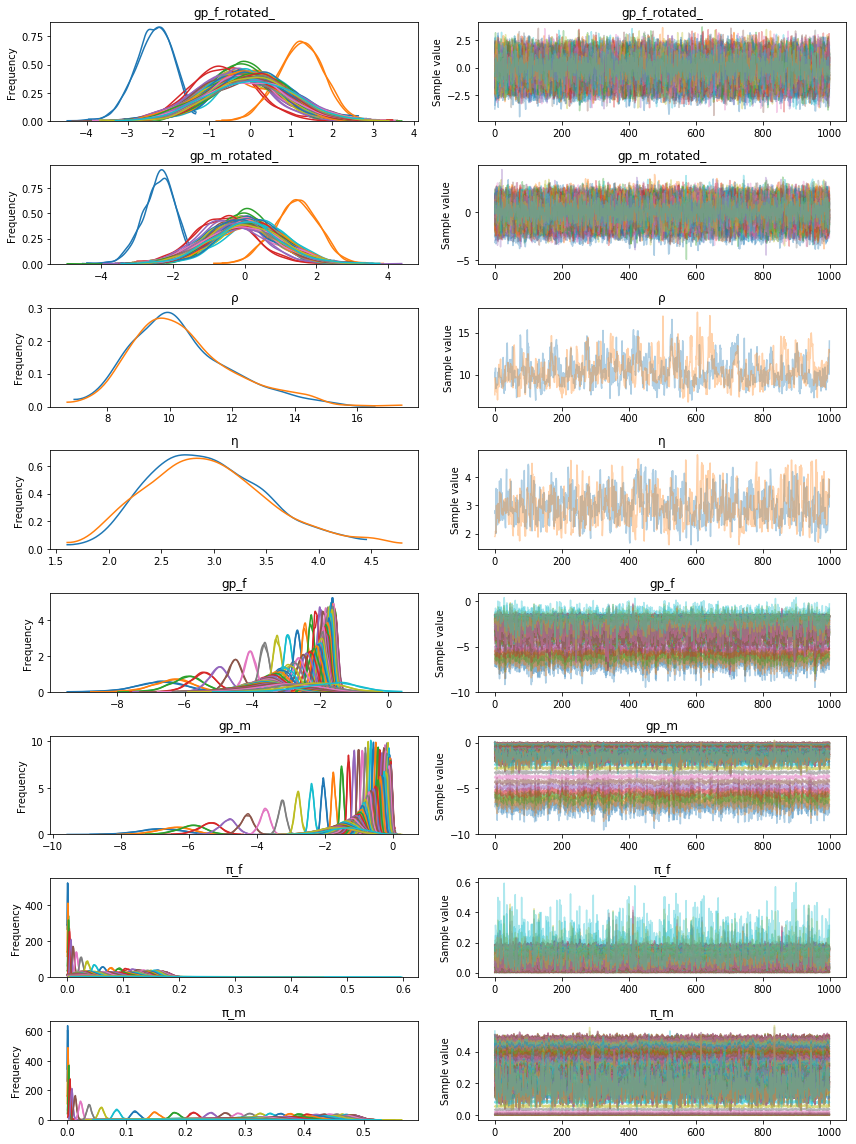

In [79]:
_ = pm.traceplot(samples)

In [71]:
prob_m = samples['π_m'].mean(axis=0)
prob_m_sd = samples['π_m'].std(axis=0, ddof=1)

prob_f = samples['π_f'].mean(axis=0)
prob_f_sd = samples['π_f'].std(axis=0, ddof=1)

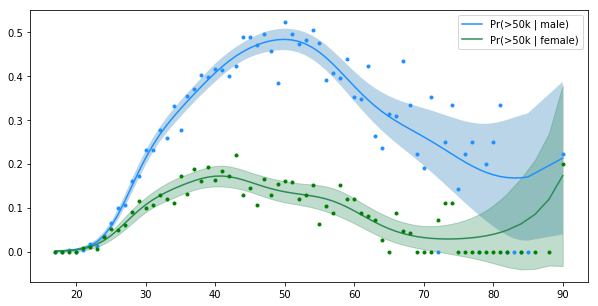

In [85]:
f, ax = plt.subplots(figsize=(10,5))
ax.plot(m_age, prob_m, label='Pr(>50k | male)', color='dodgerblue')
ax.fill_between(m_age.squeeze(), prob_m + 2*prob_m_sd, prob_m - 2*prob_m_sd, alpha=0.3)
ax.plot(m_age, m_over50k/m_n, '.', color='dodgerblue')

ax.plot(f_age, prob_f, label='Pr(>50k | female)', color='seagreen')
ax.fill_between(f_age.squeeze(), prob_f + 2*prob_f_sd, prob_f - 2*prob_f_sd,  color='seagreen', alpha=0.3)
ax.plot(f_age, f_over50k/f_n, '.g')

ax.legend()

## Let's do this again but include education as another gaussian process

In [145]:
summ_data.edu.unique()

cat_1 = ['11th', '7th-8th', '9th', '5th-6th', '10th', '1st-4th', 'Preschool', '12th']
cat_2 = ['HS-grad']
cat_3 = ['Some-college', 'Assoc-acdm']
cat_4 = ['Assoc-voc', 'Prof-school']
cat_5 = ['Bachelors']
cat_6 = ['Masters']
cat_7 = ['Doctorate']
categories = [cat_1, cat_2, cat_3, cat_4, cat_5, cat_6, cat_7]

labels = [0, 1, 2, 3, 4, 5, 6]

cat_map = {}
for cat, label in zip(categories, labels):
    for c in cat:
        cat_map[c] = label

summ_data['edu_cat'] = summ_data.edu.map(cat_map)

In [167]:
labels_str = ["Some HS", "HS Grad", "Some College", "Prof School", "Bachelors", "Masters", "Doctorate"]


In [146]:
females = summ_data[summ_data.sex == "Female"].groupby(['age','edu_cat','earning'])['marital'].sum().unstack('earning')
females = females.reset_index().fillna(0.0)
females['n'] = females["<=50K"] + females[">50K"]

males = summ_data[summ_data.sex == "Male"].groupby(['age','edu_cat','earning'])['marital'].sum().unstack('earning')
males = males.reset_index().fillna(0.0)
males['n'] = males["<=50K"] + males[">50K"]


In [154]:
#Needs to be a column vector
age_vals = females.age.unique().reshape(-1,1)
age_vals.sort()

f_over50k = females['>50K'].values
f_n = females.n.values
f_age_idx = females['age'].astype('category').cat.codes.values
f_edu_idx = females['edu_cat'].values

m_over50k = males['>50K'].values
m_n = males.n.values
m_age_idx = males['age'].astype('category').cat.codes.values
m_edu_idx = males['edu_cat'].values

edu_vals = females['edu_cat'].unique().reshape(-1,1)
edu_vals

array([[0],
       [1],
       [2],
       [3],
       [4],
       [5],
       [6]])

In [155]:
with pm.Model() as admit_m:
    rho = pm.Exponential('ρ', 1)
    eta = pm.Exponential('η', 1)
    
    rho_edu = pm.Exponential('ρ_edu', 1)
    eta_edu = pm.Exponential('η_edu', 1)
    
    K = eta**2 * pm.gp.cov.ExpQuad(1, rho)
    K_edu = eta_edu**2 * pm.gp.cov.ExpQuad(1, rho_edu)
    
    gp1 = pm.gp.Latent(cov_func=K)
    gp2 = pm.gp.Latent(cov_func=K)
    gp_edu = pm.gp.Latent(cov_func=K_edu)
    
    f = gp1.prior('gp_f', X=age_vals)
    m = gp2.prior('gp_m', X=age_vals)
    edu = gp_edu.prior('gp_edu', X=edu_vals)
    
    pi_f = pm.Deterministic('π_f', pm.invlogit(f[f_age_idx] + edu[f_edu_idx]))
    pi_m = pm.Deterministic('π_m', pm.invlogit(m[m_age_idx] + edu[m_edu_idx]))
    
    earning_f = pm.Binomial('female_over50k', p = pi_f, n=f_n.astype(int), 
                           observed=f_over50k.astype(int))
    earning_m = pm.Binomial('male_over50k', p = pi_m, n=m_n.astype(int), 
                           observed=m_over50k.astype(int))

In [156]:
samples = pm.sample(1000, model=admit_m)    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [gp_edu_rotated_, gp_m_rotated_, gp_f_rotated_, η_edu_log__, ρ_edu_log__, η_log__, ρ_log__]
100%|██████████| 1500/1500 [22:13<00:00,  1.12it/s]
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


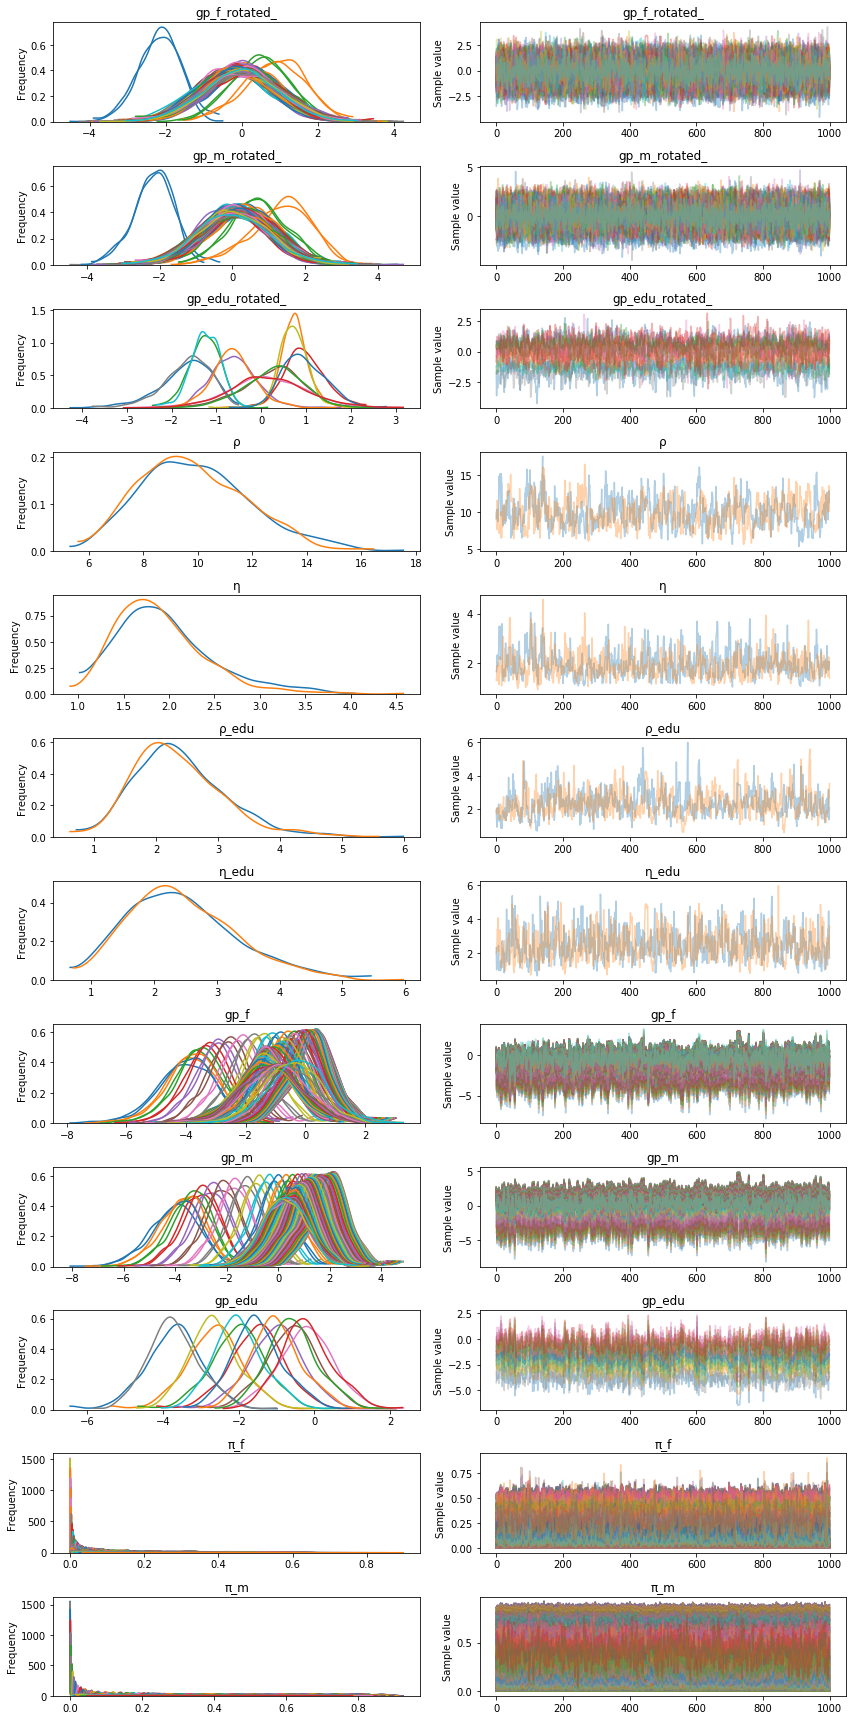

In [157]:
_ = pm.traceplot(samples)

In [158]:
prob_m = samples['π_m'].mean(axis=0)
prob_m_sd = samples['π_m'].std(axis=0, ddof=1)

prob_f = samples['π_f'].mean(axis=0)
prob_f_sd = samples['π_f'].std(axis=0, ddof=1)

In [162]:
males['post_prob'] = prob_m
males['post_sd'] = prob_m_sd

females['post_prob'] = prob_f
females['post_sd'] = prob_f_sd

In [172]:
df_m

earning,age,edu_cat,<=50K,>50K,n,post_prob,post_sd
55,27,6,1.0,0.0,1.0,0.416379,0.041648
62,28,6,2.0,0.0,2.0,0.489700,0.042053
69,29,6,3.0,1.0,4.0,0.552767,0.040767
76,30,6,3.0,2.0,5.0,0.604518,0.038776
83,31,6,2.0,2.0,4.0,0.645840,0.036827
90,32,6,0.0,2.0,2.0,0.678528,0.035165
97,33,6,1.0,4.0,5.0,0.704489,0.033705
104,34,6,0.0,5.0,5.0,0.725407,0.032347
111,35,6,1.0,4.0,5.0,0.742546,0.031046
118,36,6,2.0,1.0,3.0,0.756844,0.029857


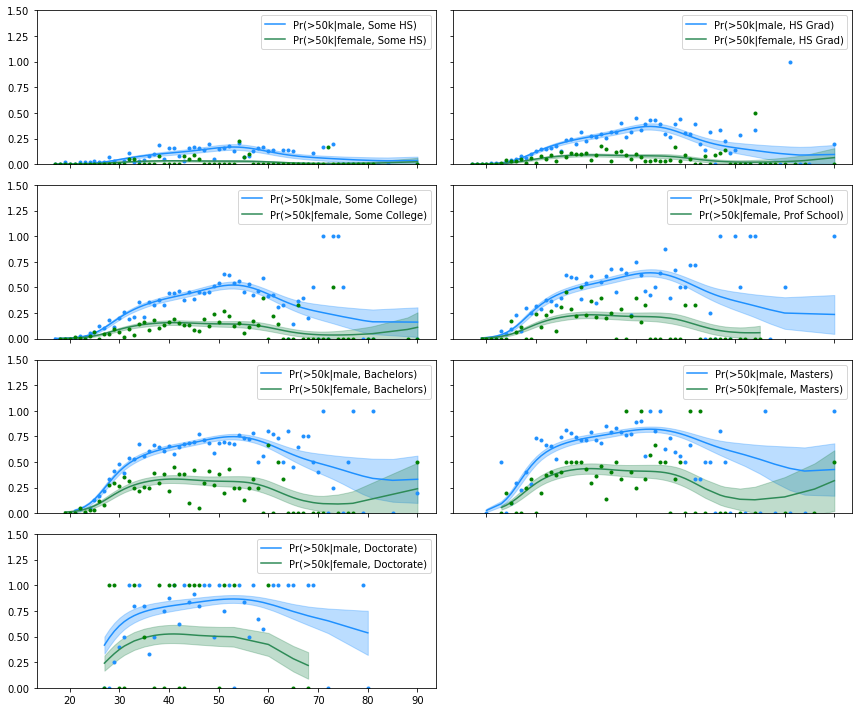

In [188]:
f, axes = plt.subplots(4,2, figsize=(12,10), sharex=True, sharey=True)

for e_cat, ax in zip(range(7), axes.ravel()):
    df_m = males[males.edu_cat == e_cat]
    df_f = females[females.edu_cat == e_cat]
    
    ax.plot(df_m.age, df_m.post_prob, label="Pr(>50k|male, %s)" % labels_str[e_cat], color='dodgerblue')
    ax.fill_between(df_m.age, df_m.post_prob + 2*df_m.post_sd, 
                    df_m.post_prob - 2*df_m.post_sd,  color='dodgerblue', alpha=0.3)
    ax.plot(df_m.age, df_m['>50K']/df_m.n, '.', c='dodgerblue')

    ax.plot(df_f.age, df_f.post_prob, 'seagreen', label="Pr(>50k|female, %s)" % labels_str[e_cat], )
    ax.fill_between(df_f.age, df_f.post_prob + 2*df_f.post_sd, 
                    df_f.post_prob - 2*df_f.post_sd,  color='seagreen', alpha=0.3)
    ax.plot(df_f.age, df_f['>50K']/df_f.n, '.g')
    
    ax.legend(loc=1)
ax.set_ybound(0, 1.5)
f.delaxes(axes.ravel()[-1])

plt.tight_layout()
plt.savefig("./bin_gp_by_sex_e.png")

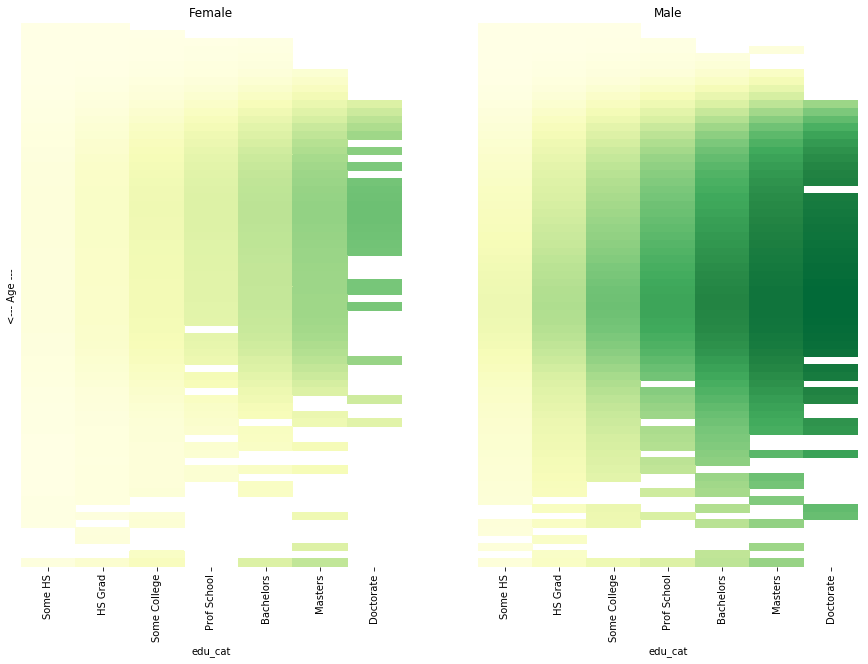

In [300]:
f, axes = plt.subplots(1,2, figsize=(15,10), sharex=True, sharey=True)

sns.heatmap(females.pivot('age','edu_cat','post_prob'), ax=axes[0], vmin=0, xticklabels=labels_str, yticklabels="",
            vmax=1,cbar=False, cmap='YlGn')
axes[0].set_title("Female")
axes[0].set_ylabel("<--- Age --- ")

sns.heatmap(males.pivot('age','edu_cat','post_prob'),  ax=axes[1], vmin=0, xticklabels=labels_str, yticklabels="",
            vmax=1,cbar=False,  cmap='YlGn')
axes[1].set_ylabel("")
axes[1].set_title("Male")
plt.savefig("./bin_gp_sample.png")

In [230]:
age_m = samples['gp_m']
age_f = samples['gp_f']
edu_gp = samples['gp_edu']

In [247]:
female_pp = np.zeros((len(age_vals),len(edu_vals),2000))
male_pp = np.zeros((len(age_vals),len(edu_vals),2000))

for i in tqdm(range(len(age_vals))):
    for j in edu_vals:
        female_pp[i,j,:] = pm.invlogit(age_f[:,i].reshape(-1,1) + edu_gp[:,j].reshape(-1,1)).eval().T
        male_pp[i,j,:] = pm.invlogit(age_m[:,i].reshape(-1,1) + edu_gp[:,j].reshape(-1,1)).eval().T

In [260]:
fmean_pp = pd.DataFrame(female_pp.mean(axis=2), index=age_vals.squeeze())
mmean_pp = pd.DataFrame(male_pp.mean(axis=2), index=age_vals.squeeze())

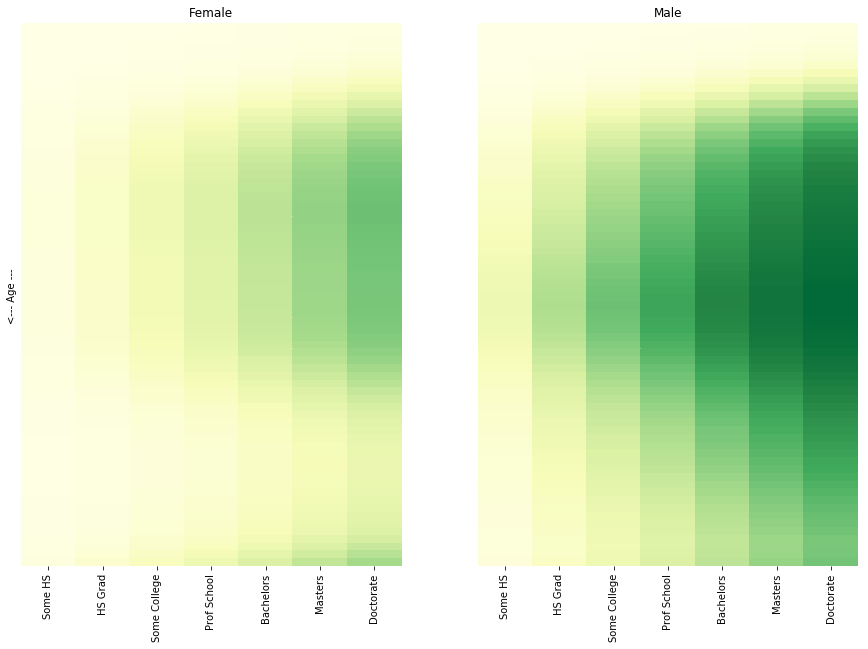

In [299]:
f, axes = plt.subplots(1,2, figsize=(15,10), sharex=True, sharey=True)
sns.heatmap(fmean_pp, ax=axes[0], vmin=0, vmax=1, cbar=False, cmap='YlGn',
           xticklabels=labels_str, yticklabels="")
axes[0].set_title("Female")
axes[0].set_ylabel("<--- Age --- ")
sns.heatmap(mmean_pp, ax=axes[1], vmin=0, vmax=1, cmap='YlGn',
            cbar=False, xticklabels=labels_str, yticklabels="")
axes[1].set_title("Male")
plt.savefig("./bin_gp_pp.png")